### Week 1 - Demos and figures

#### Pushforward examples

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm 

Discrete example

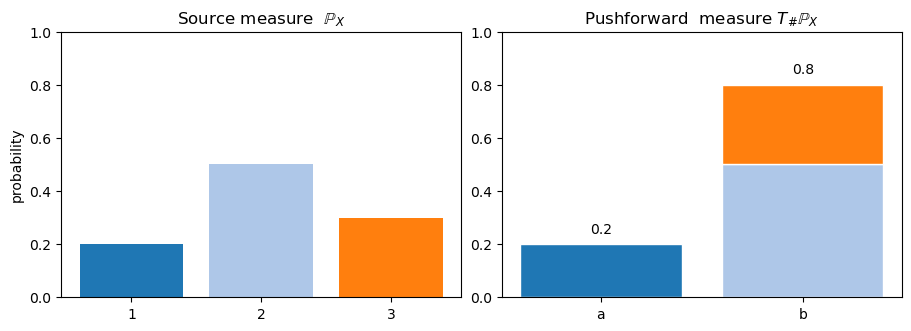

In [57]:

# Source distribution on {1,2,3}
pmf_x = {1: 0.2, 2: 0.5, 3: 0.3}

# Map T: {1,2,3} -> {a,b}
T = {1: "a", 2: "b", 3: "b"}

x_vals = [1, 2, 3]
y_vals = ["a", "b"]

# Choose consistent colors per source point
cmap = plt.get_cmap("tab20")
colors = {x: cmap(i) for i, x in enumerate(x_vals)}

# Compute contributions to each target point (for stacking)
contrib = {y: {} for y in y_vals}
for x, px in pmf_x.items():
    y = T[x]
    contrib[y][x] = px

# Total pushforward masses
pmf_y = {y: sum(contrib[y].values()) for y in y_vals}

# --- Plot ---
fig, (axL, axR) = plt.subplots(1, 2, figsize=(9, 3.2), constrained_layout=True)

# Left: source bars (colored by x)
axL.bar([str(x) for x in x_vals], [pmf_x[x] for x in x_vals],
        color=[colors[x] for x in x_vals])
axL.set_ylim(0, 1.0)
axL.set_title("Source measure  $\\mathbb{P}_X$")
axL.set_ylabel("probability")

# Right: target bars as stacked contributions (same colors as source)
for j, y in enumerate(y_vals):
    bottom = 0.0
    # stack in source order for consistency
    for x in x_vals:
        h = contrib[y].get(x, 0.0)
        if h > 0:
            axR.bar(y, h, bottom=bottom, color=colors[x], edgecolor="white", linewidth=1.0)
            bottom += h

# Outline total bar height + annotate totals
axR.set_ylim(0, 1.0)
axR.set_title("Pushforward  measure $T_\\#\\mathbb{P}_X$")
for y in y_vals:
    axR.text(y, pmf_y[y] + 0.03, f"{pmf_y[y]:.1f}", ha="center", va="bottom")

# Legend: which color corresponds to which source point
handles = [plt.Rectangle((0, 0), 1, 1, color=colors[x]) for x in x_vals]
labels = [f"mass from x={x}" for x in x_vals]
#fig.legend(handles, labels, loc="upper left", ncol=3, frameon=False)


plt.savefig("../img/week1_pushforward_discrete.pdf", format="pdf", bbox_inches="tight")



Continuous example

In [54]:

# Functions

# ----------------------------
# Generic sampler from a 1D density p(x) on [x_min, x_max]
# via discretize -> normalize -> CDF -> inverse transform
# ----------------------------
def sample_from_density_grid(p, x_min, x_max, size, rng, grid_n=200_000):
    xs = np.linspace(x_min, x_max, grid_n)
    fx = p(xs).astype(float)

    # basic safety
    fx = np.clip(fx, 0.0, np.inf)
    area = np.trapezoid(fx, xs)
    if not np.isfinite(area) or area <= 0:
        raise ValueError("Density integrates to 0 or is not finite on the chosen support.")

    fx /= area  # normalize on [x_min, x_max]

    # build CDF
    dx = xs[1] - xs[0]
    cdf = np.cumsum(fx) * dx
    cdf[-1] = 1.0  # enforce exact endpoint

    u = rng.random(size)
    return np.interp(u, cdf, xs)

def colored_pushforward_hist(pX, T, N=10, M=300_000, y_bins=60, seed=0,
                            x_support=(-8.0, 8.0), grid_n=200_000,
                            source_title = 'Source', map_title='Map'):
    rng = np.random.default_rng(seed)

    # 1) sample from the user-defined density pX (on a finite support)
    x = sample_from_density_grid(pX, x_support[0], x_support[1], size=M, rng=rng, grid_n=grid_n)
    y = T(x)

    # 2) bin X into N quantile bins (≈ equal mass per colour)
    x_edges = np.quantile(x, np.linspace(0.0, 1.0, N + 1))

    # 3) make Y histogram bin edges (robust range)
    lo, hi = np.quantile(y, [0.001, 0.999])
    if lo == hi:
        lo, hi = y.min(), y.max()
    pad = 0.05 * (hi - lo + 1e-12)
    y_edges = np.linspace(lo - pad, hi + pad, y_bins + 1)

    # assign each x to a bin index 0..N-1
    x_bin = np.digitize(x, x_edges[1:-1], right=False)

    # prepare stacked inputs for ax.hist
    y_by_bin = [y[x_bin == i] for i in range(N)]
    w_by_bin = [np.full(len(arr), 1.0 / M) for arr in y_by_bin]  # probability mass weights

    # Colors
    cmap = plt.get_cmap("tab10") if N <= 10 else plt.get_cmap("tab20")
    colors = [cmap(i % cmap.N) for i in range(N)]

    # 4) plot: left (source bins) + right (stacked histogram with vertical sides)
    fig, (axL, axR) = plt.subplots(1, 2, figsize=(11, 3.6), constrained_layout=True)

    # Left: density curve + coloured bin regions
    xx = np.linspace(x_support[0], x_support[1], 2000)
    axL.plot(xx, pX(xx), linewidth=2)

    for i in range(N):
        a, b = x_edges[i], x_edges[i + 1]
        mask = (xx >= a) & (xx <= b)
        axL.fill_between(xx[mask], 0, pX(xx[mask]), alpha=0.45, color=colors[i])

    axL.set_title(f"Source: {source_title} (binned into N={N})")
    axL.set_xlabel("$x$")
    axL.set_ylabel("density")
    axL.spines["top"].set_visible(False)
    axL.spines["right"].set_visible(False)

    # Right: REAL histogram rectangles (vertical sides), stacked by source-bin colour
    axR.hist(
        y_by_bin,
        bins=y_edges,
        weights=w_by_bin,
        stacked=True,
        histtype="barstacked",   # <-- rectangular bars (not filled curves)
        color=colors,
        edgecolor="white",       # <-- shows vertical bin boundaries clearly
        linewidth=0.7,
        alpha=0.9
    )

    axR.set_title(f"Pushforward histogram via {map_title}")
    axR.set_xlabel("$y$")
    axR.set_ylabel("probability mass per bin")
    axR.spines["top"].set_visible(False)
    axR.spines["right"].set_visible(False)

    # Legend: each colour corresponds to an X-bin interval
    labels = [f"[{x_edges[i]:.2f}, {x_edges[i+1]:.2f})" for i in range(N)]
    handles = [plt.Rectangle((0, 0), 1, 1, color=colors[i], alpha=0.9) for i in range(N)]
    axR.legend(handles, labels, title="X-bin (source)", frameon=False,
               bbox_to_anchor=(1.02, 1.0), loc="upper left")

    #plt.show()



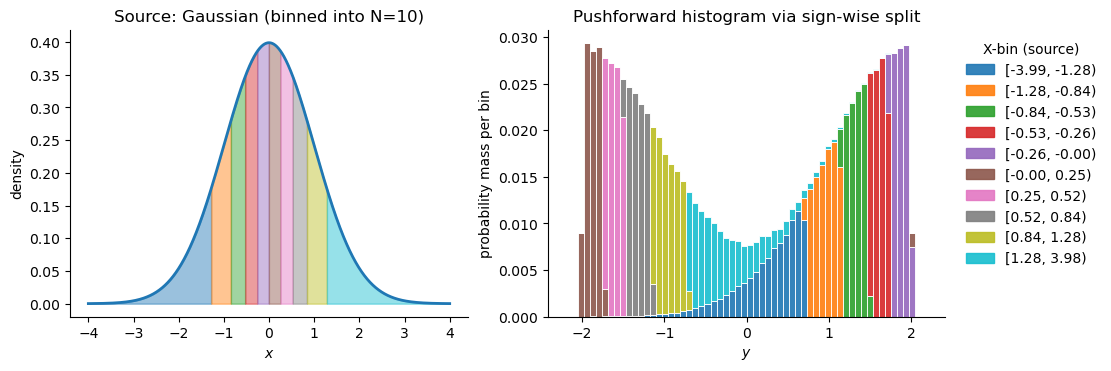

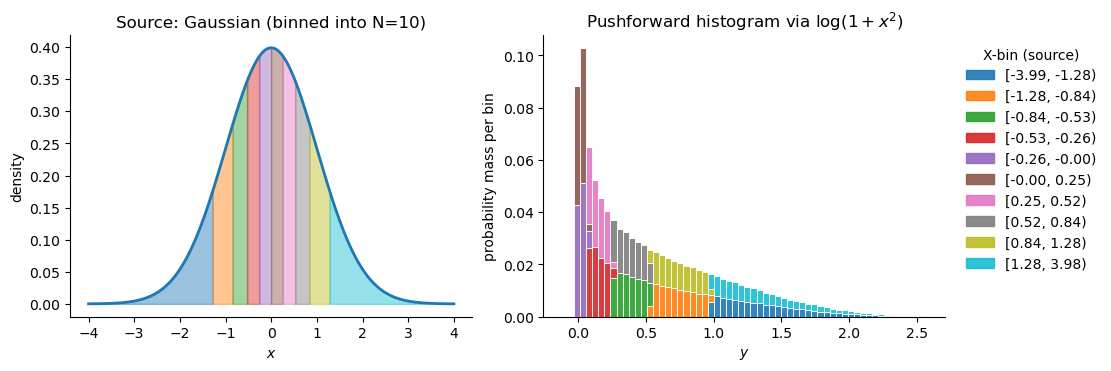

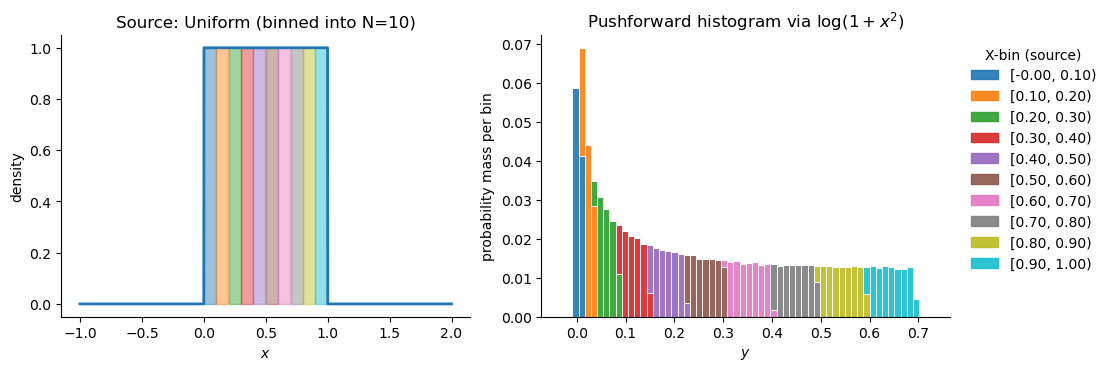

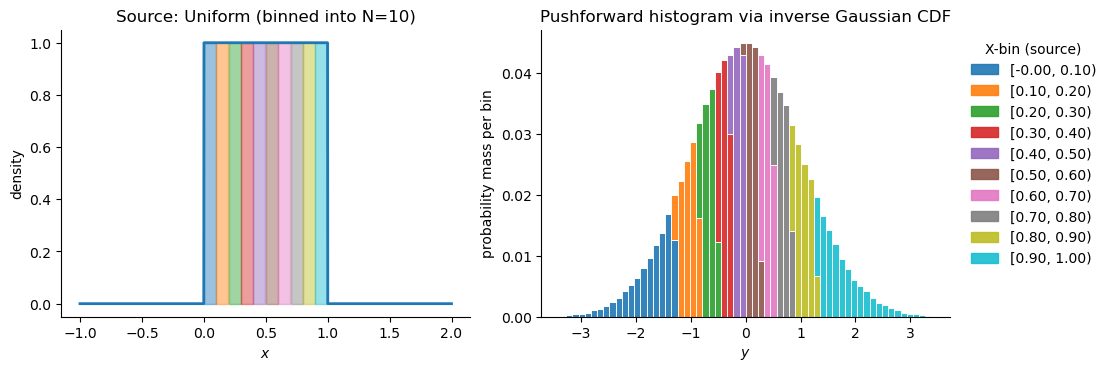

In [55]:
# ----------------------------
# Define source density pX and map T
# ----------------------------

def pX(x):
    return (1.0 / np.sqrt(2*np.pi)) * np.exp(-0.5 * x**2)

def T(x):
    x = np.asarray(x)
    return np.where(x < 0, x + 2.0, x - 2.0)


# Run it
colored_pushforward_hist(pX, T, N=10, M=300_000, y_bins=60, seed=1, x_support=(-4, 4), source_title='Gaussian', map_title='sign-wise split')
plt.savefig("../img/week1_pushforward_Gaussian_split.pdf", format="pdf", bbox_inches="tight")



def T(x):
    return np.log(1+x**2)

# Run it
colored_pushforward_hist(pX, T, N=10, M=300_000, y_bins=60, seed=1, x_support=(-4, 4), source_title='Gaussian', map_title='$\\log(1+x^2)$')
plt.savefig("../img/week1_pushforward_Gaussian_log_sq.pdf", format="pdf", bbox_inches="tight")



def pX(x):
    x = np.asarray(x)
    return np.where((-0.0 <= x) & (x <= 1.0), 1, 0.0)

# Run it
colored_pushforward_hist(pX, T, N=10, M=300_000, y_bins=60, seed=1, x_support=(-1, 2), source_title='Uniform', map_title='$\\log(1+x^2)$')
plt.savefig("../img/week1_pushforward_unif_log_sq.pdf", format="pdf", bbox_inches="tight")


def T(u):
    u = np.asarray(u)
    u = np.clip(u, 1e-12, 1 - 1e-12)  # avoid +/- inf at 0 or 1
    return norm.ppf(u)

# Run it
colored_pushforward_hist(pX, T, N=10, M=300_000, y_bins=60, seed=1, x_support=(-1, 2), source_title='Uniform', map_title='inverse Gaussian CDF')
plt.savefig("../img/week1_pushforward_unif_GaussianQF.pdf", format="pdf", bbox_inches="tight")



